# Exame the Analysis about Depth on Fashion-MNIST Dataset

In this notebook, we examine the conclusion that deep feed-forward neural networks need the combination of three factors for controlling gradients in the training process. These factors are: residual structure, regularization, and normalization.

For regularization, we use `AdamW` optimizer, in which weight decay serves the regularization. And for normalization, we employ layer-normalization.

We train several models, with none or one of these factors are fulfilled. And finally, we train a model with all three factors satisfied. For each model, we examine the training loss for a fixed training epochs. We also explicitly check the norm of the Jacobian matrix $\partial r_l / \partial z_l$ for a given hidden layer $l$.

## Defining Data and Model

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from typing import List
import matplotlib.pyplot as plt

In [2]:
dataset = tf.keras.datasets.fashion_mnist
(X_train, y_train), _ = dataset.load_data()

In [3]:
X_train = tf.cast(X_train, 'float32') / 255
X_train = tf.reshape(X_train, [-1, 28*28])

In [4]:
class Block(tf.keras.layers.Layer):

    def __init__(self, hidden_units: List[int],
                 use_normalization: bool,
                 use_residual: bool,
                 **kwargs):
        super().__init__(**kwargs)
        self.hidden_units = hidden_units
        self.use_normalization = use_normalization
        self.use_residual = use_residual

        self.normalization = LayerNormalization()
        self.feedforward = Sequential([Dense(n, 'relu') for n in hidden_units])

    def call(self, x):
        y = x
        if self.use_normalization:
            y = self.normalization(y)
        y = self.feedforward(y)
        if self.use_residual:
            y += x
        return y

In [5]:
def build_model(hidden_units, num_blocks, block_fn, optimizer):
    layers = []
    layers.append(Dense(hidden_units[-1]))  # embedding layer.
    for _ in range(num_blocks):
        layers.append(block_fn(hidden_units))
    layers.append(tf.keras.layers.Dense(10))  # output (logits) layer.

    model = Sequential(layers)
    model.compile(
        optimizer=optimizer,
        loss=SparseCategoricalCrossentropy(from_logits=True),
    )
    model.fit(
        X_train, y_train, batch_size=64, epochs=10, verbose=2,
    )
    return model

## Examinations

### Training and Examining Training Loss

In [6]:
shallow_baseline_model = build_model([64], 2, lambda ns: Block(ns, False, False), Adam())

Epoch 1/10
938/938 - 9s - loss: 0.5512 - 9s/epoch - 10ms/step
Epoch 2/10
938/938 - 4s - loss: 0.4051 - 4s/epoch - 4ms/step
Epoch 3/10
938/938 - 4s - loss: 0.3643 - 4s/epoch - 4ms/step
Epoch 4/10
938/938 - 4s - loss: 0.3378 - 4s/epoch - 5ms/step
Epoch 5/10
938/938 - 2s - loss: 0.3211 - 2s/epoch - 3ms/step
Epoch 6/10
938/938 - 2s - loss: 0.3061 - 2s/epoch - 2ms/step
Epoch 7/10
938/938 - 2s - loss: 0.2959 - 2s/epoch - 2ms/step
Epoch 8/10
938/938 - 2s - loss: 0.2854 - 2s/epoch - 2ms/step
Epoch 9/10
938/938 - 3s - loss: 0.2769 - 3s/epoch - 3ms/step
Epoch 10/10
938/938 - 3s - loss: 0.2701 - 3s/epoch - 3ms/step


In [7]:
baseline_model = build_model([64], 30, lambda ns: Block(ns, False, False), Adam())

Epoch 1/10
938/938 - 18s - loss: 1.2757 - 18s/epoch - 19ms/step
Epoch 2/10
938/938 - 9s - loss: 0.8780 - 9s/epoch - 10ms/step
Epoch 3/10
938/938 - 9s - loss: 0.7467 - 9s/epoch - 10ms/step
Epoch 4/10
938/938 - 8s - loss: 1.0018 - 8s/epoch - 9ms/step
Epoch 5/10
938/938 - 9s - loss: 1.0379 - 9s/epoch - 10ms/step
Epoch 6/10
938/938 - 9s - loss: 0.9082 - 9s/epoch - 10ms/step
Epoch 7/10
938/938 - 8s - loss: 0.8713 - 8s/epoch - 9ms/step
Epoch 8/10
938/938 - 12s - loss: 0.8171 - 12s/epoch - 13ms/step
Epoch 9/10
938/938 - 9s - loss: 0.9064 - 9s/epoch - 10ms/step
Epoch 10/10
938/938 - 9s - loss: 0.7702 - 9s/epoch - 10ms/step


In [8]:
baseline_model_with_norm = build_model([64], 30, lambda ns: Block(ns, True, False), Adam())

Epoch 1/10
938/938 - 49s - loss: 1.3152 - 49s/epoch - 52ms/step
Epoch 2/10
938/938 - 27s - loss: 1.1218 - 27s/epoch - 29ms/step
Epoch 3/10
938/938 - 27s - loss: 1.1145 - 27s/epoch - 29ms/step
Epoch 4/10
938/938 - 27s - loss: 0.9968 - 27s/epoch - 29ms/step
Epoch 5/10
938/938 - 27s - loss: 0.9139 - 27s/epoch - 29ms/step
Epoch 6/10
938/938 - 28s - loss: 1.6524 - 28s/epoch - 30ms/step
Epoch 7/10
938/938 - 27s - loss: 2.3027 - 27s/epoch - 29ms/step
Epoch 8/10
938/938 - 27s - loss: 2.3026 - 27s/epoch - 29ms/step
Epoch 9/10
938/938 - 27s - loss: 2.3026 - 27s/epoch - 29ms/step
Epoch 10/10
938/938 - 28s - loss: 2.3026 - 28s/epoch - 30ms/step


In [9]:
baseline_model_with_res = build_model([64], 30, lambda ns: Block(ns, False, True), Adam())

Epoch 1/10
938/938 - 19s - loss: 249.8732 - 19s/epoch - 20ms/step
Epoch 2/10
938/938 - 10s - loss: 1.7727 - 10s/epoch - 10ms/step
Epoch 3/10
938/938 - 9s - loss: 1.2089 - 9s/epoch - 9ms/step
Epoch 4/10
938/938 - 9s - loss: 0.9698 - 9s/epoch - 10ms/step
Epoch 5/10
938/938 - 10s - loss: 0.8343 - 10s/epoch - 10ms/step
Epoch 6/10
938/938 - 10s - loss: 0.7121 - 10s/epoch - 10ms/step
Epoch 7/10
938/938 - 9s - loss: 0.6340 - 9s/epoch - 9ms/step
Epoch 8/10
938/938 - 9s - loss: 0.5781 - 9s/epoch - 10ms/step
Epoch 9/10
938/938 - 10s - loss: 0.5188 - 10s/epoch - 10ms/step
Epoch 10/10
938/938 - 10s - loss: 0.4928 - 10s/epoch - 10ms/step


In [10]:
baseline_model_with_adamw = build_model([64], 30, lambda ns: Block(ns, False, False), AdamW())

Epoch 1/10
938/938 - 20s - loss: 1.2135 - 20s/epoch - 22ms/step
Epoch 2/10
938/938 - 11s - loss: 0.9097 - 11s/epoch - 12ms/step
Epoch 3/10
938/938 - 11s - loss: 0.7353 - 11s/epoch - 12ms/step
Epoch 4/10
938/938 - 11s - loss: 0.7277 - 11s/epoch - 12ms/step
Epoch 5/10
938/938 - 10s - loss: 0.6753 - 10s/epoch - 11ms/step
Epoch 6/10
938/938 - 11s - loss: 0.6708 - 11s/epoch - 11ms/step
Epoch 7/10
938/938 - 11s - loss: 0.7298 - 11s/epoch - 12ms/step
Epoch 8/10
938/938 - 11s - loss: 0.7472 - 11s/epoch - 12ms/step
Epoch 9/10
938/938 - 11s - loss: 0.6358 - 11s/epoch - 11ms/step
Epoch 10/10
938/938 - 11s - loss: 0.6384 - 11s/epoch - 11ms/step


In [11]:
model = build_model([64], 30, lambda ns: Block(ns, True, True), AdamW())

Epoch 1/10
938/938 - 55s - loss: 0.6573 - 55s/epoch - 58ms/step
Epoch 2/10
938/938 - 31s - loss: 0.4295 - 31s/epoch - 33ms/step
Epoch 3/10
938/938 - 32s - loss: 0.3903 - 32s/epoch - 34ms/step
Epoch 4/10
938/938 - 32s - loss: 0.3533 - 32s/epoch - 34ms/step
Epoch 5/10
938/938 - 32s - loss: 0.3307 - 32s/epoch - 35ms/step
Epoch 6/10
938/938 - 31s - loss: 0.3125 - 31s/epoch - 33ms/step
Epoch 7/10
938/938 - 31s - loss: 0.2962 - 31s/epoch - 33ms/step
Epoch 8/10
938/938 - 31s - loss: 0.2869 - 31s/epoch - 33ms/step
Epoch 9/10
938/938 - 32s - loss: 0.2727 - 32s/epoch - 34ms/step
Epoch 10/10
938/938 - 32s - loss: 0.2594 - 32s/epoch - 34ms/step


### Examining Eigenvalues of Jacobian Matrix

In [12]:
model.summary()

Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                50240     
                                                                 
 block_122 (Block)           (None, 64)                4288      
                                                                 
 block_123 (Block)           (None, 64)                4288      
                                                                 
 block_124 (Block)           (None, 64)                4288      
                                                                 
 block_125 (Block)           (None, 64)                4288      
                                                                 
 block_126 (Block)           (None, 64)                4288      
                                                                 
 block_127 (Block)           (None, 64)             

In [96]:
def examine_jacobian(model, block_idx, x):
    x = tf.expand_dims(x, 0)
    with tf.GradientTape() as tape:
        y = model.layers[0](x)  # embedding layer.
        for i in range(block_idx):
            x = y
            y = model.layers[i+1](x)
    jacobian = tape.jacobian(y, x)  # [1, n, 1, n]
    jacobian = jacobian[0, :, 0, :]  # [n, n]
    if model.layers[block_idx].use_residual:
        jacobian -= tf.eye(x.shape[1], x.shape[1])
    jacobian = jacobian.numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    # histogram excluding zeros
    axs[0].hist(jacobian[jacobian != 0].reshape([-1]), bins=50)
    axs[0].grid()
    # imshow
    imshow = axs[1].imshow(jacobian)
    plt.colorbar(imshow, ax=axs[1])
    # show the figure
    fig.suptitle('Histogram excluding zeros (left) and imshow (right).')
    plt.show()

In [97]:
test_layer = 20
test_x = X_train[100]

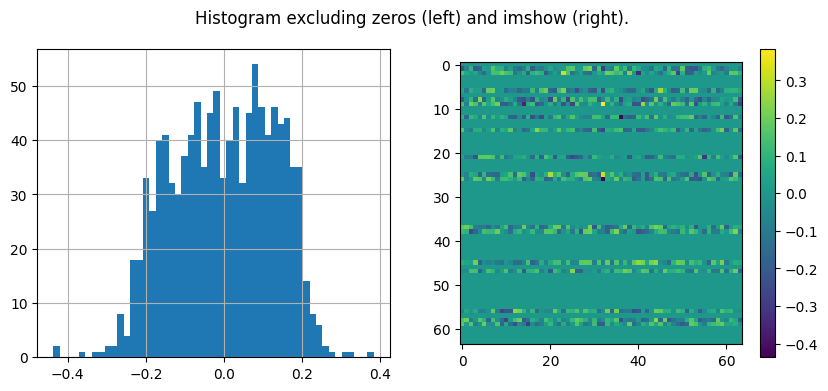

In [98]:
examine_jacobian(baseline_model, test_layer, test_x)

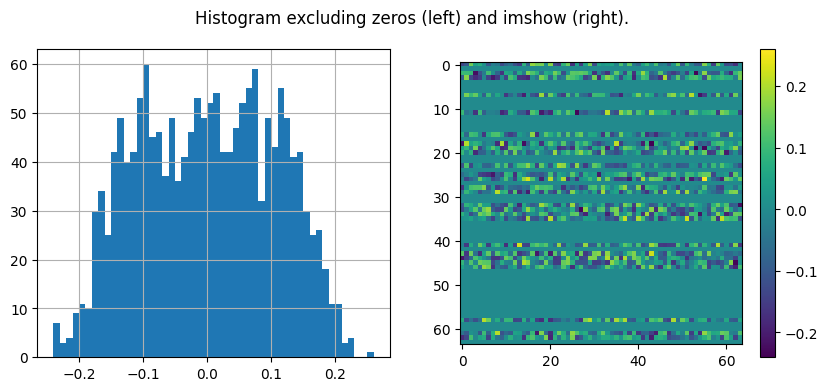

In [99]:
examine_jacobian(baseline_model_with_norm, test_layer, test_x)

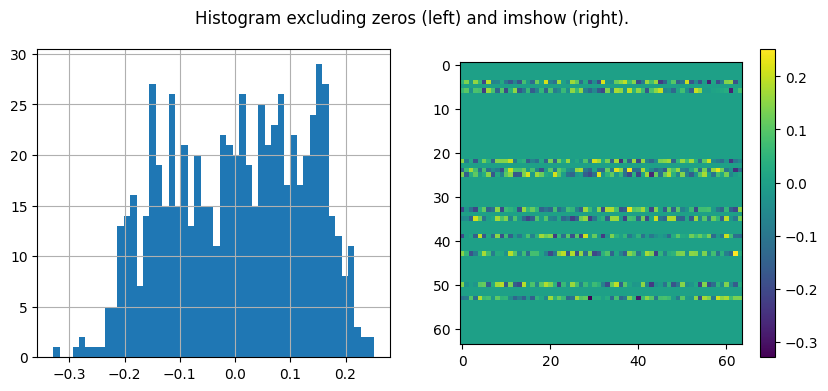

In [100]:
examine_jacobian(baseline_model_with_adamw, test_layer, test_x)

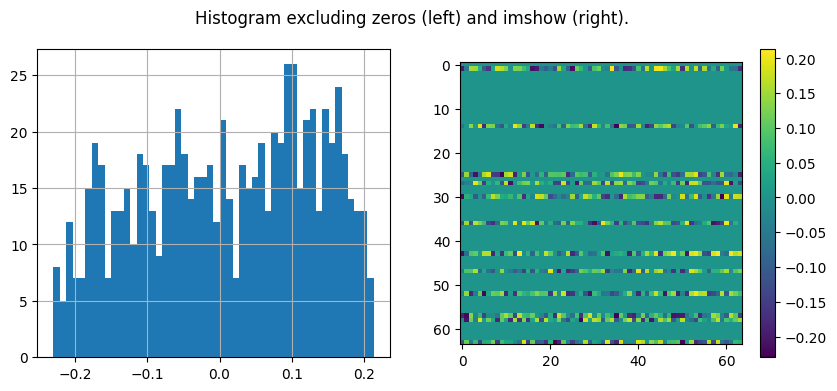

In [101]:
examine_jacobian(baseline_model_with_res, test_layer, test_x)

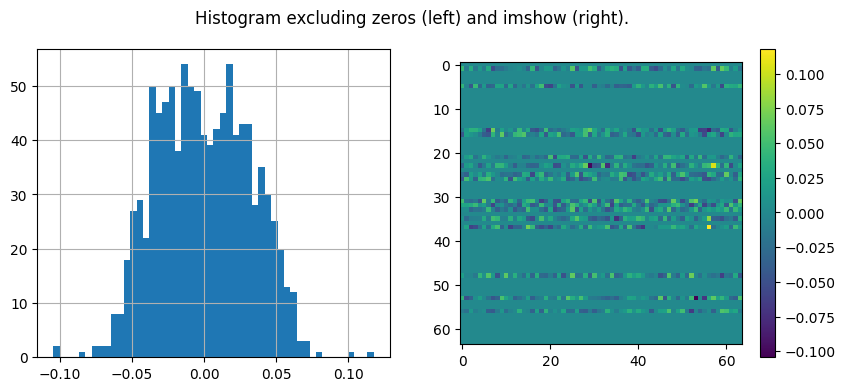

In [102]:
examine_jacobian(model, test_layer, test_x)

## Conclusion

It is found that:

1. the model that satisfies all the factors significantly out-performs the others;
1. the model with residual structure only already has great performance, even though with the aid of regularization and normalization the performace improves further;
1. the Jacobian matrix $\partial r_l / \partial z_l$ at layer $l$ reflects the performance directly: the smaller norm of Jacobian matrix, the greater performance it has on training loss;
1. and for those model with great performance, the norms of the Jacobian matrix of most hidden layers are bounded to a small neighbourhood of zero; the gradients thus are controlled during the training process.

So, this numerical examination is consistent with our theoretical analysis.